In [1]:
#Sandesh
import os
import numpy as np
from PIL import Image

def LoadSceneAndLabel(dirnameScene, dirnameLabel, numImages):
    count = 0
    sceneX = []
    sceneY = []
    for sceneName in os.listdir(dirnameScene):
        scene = Image.open(os.path.join(dirnameScene, sceneName))
        sceneLabel = Image.open(os.path.join(dirnameLabel, sceneName[:-4]+"_drivable_color.png"))
        #scene.show()
        #sceneLabel.show()
        #print(scene.size)
        #print(sceneLabel.size)
        sceneX.append(scene)
        sceneY.append(sceneLabel)
        count += 1
        if count >= numImages:
          break
    return sceneX, sceneY

dataX, dataY = LoadSceneAndLabel(dirnameScene="bdd100k_images/images/100k/train", dirnameLabel="bdd100k_drivable_map/drivable_maps/color_labels/train", numImages=50)
valX, valY = LoadSceneAndLabel(dirnameScene="bdd100k_images/images/100k/val", dirnameLabel="bdd100k_drivable_map/drivable_maps/color_labels/val", numImages=50)

dataX[0].size

xSize = 720
ySize = 1280

In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Compress

In [3]:
import math

def compress(x, y, rate=0.1):  # compress one image and its label image
    global xSize
    global ySize
    #print(x.size)
    xSize = math.floor(x.size[0]*rate)
    ySize = math.floor(x.size[1]*rate)
    
    x = x.resize([xSize, ySize])  
    y = y.resize([xSize, ySize])  
    #print(x.size)

    return x, y

In [4]:
x = dataX[0]
y = dataY[0]

In [5]:
x, y = compress(x, y, rate=0.1)

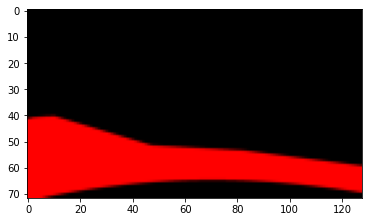

In [6]:
plt.imshow(y)

# Transform - flips

In [7]:


# 

# #list is pass by reference so copy isn't made
import torchvision.transforms.functional as TF
import random

def transformImages(image, mask):


    # Random horizontal flipping
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

        # Random vertical flipping
#         if random.random() > 0.5:
#             image = TF.vflip(image)
#             mask = TF.vflip(mask)

#         # Transform to tensor
#         image = TF.to_tensor(image)
#         mask = TF.to_tensor(mask)
    return image, mask
    
#transform dataX and dataY, doesn't return anything since passed by reference


# Convert to array

In [8]:
# 
#convert non zero label to be the same number so it's not different based on different lane categorization

def convert_to_array(x, y):  # convert one single pair of image and label
    x = np.array(x)
    #divide by 255.0
    x = np.divide(x, 255.0)

    y = y.convert('LA')  # convert to grayscale
    y = np.squeeze(np.array(y)[:,:,0])
    y = np.where(y > 0, 1, 0)

    return x, y

In [9]:
x, y = convert_to_array(x, y)

In [10]:
x

array([[[0.32941176, 0.61176471, 0.94117647],
        [0.32941176, 0.61176471, 0.94117647],
        [0.33333333, 0.61568627, 0.94509804],
        ...,
        [0.03137255, 0.0627451 , 0.0745098 ],
        [0.02745098, 0.04705882, 0.06666667],
        [0.02352941, 0.03529412, 0.05490196]],

       [[0.3372549 , 0.61960784, 0.94901961],
        [0.34117647, 0.62352941, 0.95294118],
        [0.34117647, 0.62352941, 0.95294118],
        ...,
        [0.03529412, 0.07058824, 0.07843137],
        [0.03529412, 0.05882353, 0.0745098 ],
        [0.03529412, 0.04705882, 0.06666667]],

       [[0.34509804, 0.62745098, 0.95686275],
        [0.34509804, 0.62745098, 0.95686275],
        [0.34509804, 0.62745098, 0.95686275],
        ...,
        [0.03529412, 0.0745098 , 0.08235294],
        [0.04313725, 0.06666667, 0.07843137],
        [0.04313725, 0.05490196, 0.0745098 ]],

       ...,

       [[0.60392157, 0.6627451 , 0.58039216],
        [0.58823529, 0.64705882, 0.56862745],
        [0.59607843, 0

# Load with DataLoader

In [11]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import rgb_to_grayscale

class DatasetImgs(Dataset):
    def __init__(self, annotations_file, img_dir, label_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        #image = read_image(img_path)
        label_path = os.path.join(self.label_dir, self.img_labels.iloc[idx, 1])
        label = Image.open(label_path)
        #label = read_image(label_path)
        
        
        
        # random flip - custom method
        #image, label = transformImages(image, label)
        
        #compress
        image, label = compress(image, label, rate=0.1)
        
        # TODO - transform
        
        
        # convert to array
        image, label = convert_to_array(image, label)
        
        if self.transform:
            image = self.transform(image).cuda()
        if self.target_transform:
            label = self.target_transform(label).cuda()
        
        image = image.type(torch.FloatTensor)
        label = label.type(torch.FloatTensor)
        
        sample = {"image": image, "label": label}
        return sample

In [12]:
BATCH_SIZE = 75
VAL_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
SEED = 0

In [13]:
torch.manual_seed(SEED)

train_annotations_file = "train.csv"
val_annotations_file = "val.csv"
test_annotations_file = "test.csv"


trainX_dir = "bdd100k_images/images/100k/train"
trainY_dir = "bdd100k_drivable_map/drivable_maps/color_labels/train"

valX_dir = "bdd100k_images/images/100k/val"
valY_dir = "bdd100k_drivable_map/drivable_maps/color_labels/val"

# transforms = transforms.Compose([transforms.RandomRotation(30),
#                                 transforms.Resize((72, 128)),
#                                 transforms.RandomHorizontalFlip(),
#                                 transforms.ToTensor()])

# transformsX = transforms.Compose([transforms.Resize((72, 128)),
#                                 transforms.ToTensor()])
# transformsY = transforms.Compose([transforms.Grayscale(),
#                                 transforms.Resize((72, 128)),
#                                 transforms.ToTensor()])






# train_dataset = DatasetImgs(train_annotations_file, trainX_dir, trainY_dir, transform=transformsX, target_transform=transformsY)
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# val_dataset = DatasetImgs(val_annotations_file, valX_dir, valY_dir, transform=transformsX, target_transform=transformsY)
# val_loader = DataLoader(dataset=train_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

# test_dataset = DatasetImgs(test_annotations_file, trainX_dir, trainY_dir, transform=transformsX, target_transform=transformsY)
# test_loader = DataLoader(dataset=train_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

train_dataset = DatasetImgs(train_annotations_file, trainX_dir, trainY_dir, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = DatasetImgs(val_annotations_file, valX_dir, valY_dir, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
val_loader = DataLoader(dataset=train_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

test_dataset = DatasetImgs(test_annotations_file, trainX_dir, trainY_dir, transform=transforms.ToTensor(), target_transform=transforms.ToTensor())
test_loader = DataLoader(dataset=train_dataset, batch_size=TEST_BATCH_SIZE, shuffle=True)

In [14]:
img_labels = pd.read_csv("train.csv")
img_labels

nameX                                 nameY
0      79930740-a2e428ea.jpg  79930740-a2e428ea_drivable_color.png
1      832e2723-63312d1a.jpg  832e2723-63312d1a_drivable_color.png
2      89ee675b-bf40c5d9.jpg  89ee675b-bf40c5d9_drivable_color.png
3      3c4403cc-15a4d350.jpg  3c4403cc-15a4d350_drivable_color.png
4      4ee348f8-0887f45b.jpg  4ee348f8-0887f45b_drivable_color.png
...                      ...                                   ...
49995  58820efb-9ca3871a.jpg  58820efb-9ca3871a_drivable_color.png
49996  029e1042-2639a5f8.jpg  029e1042-2639a5f8_drivable_color.png
49997  4276675d-856280d0.jpg  4276675d-856280d0_drivable_color.png
49998  a32543af-9207d709.jpg  a32543af-9207d709_drivable_color.png
49999  359c8000-2be329f0.jpg  359c8000-2be329f0_drivable_color.png

[50000 rows x 2 columns]

(72, 128, 3)

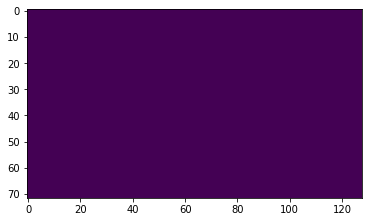

In [15]:
tensor_image = read_image("bdd100k_images/images/100k/train/5a2a8521-8c9ea049.jpg")
tensor_image

image = Image.open("bdd100k_images/images/100k/train/5a2a8521-8c9ea049.jpg")
image = image.resize([xSize, ySize])
# convert to array
image, label = convert_to_array(image, image)
plt.imshow(label)
image.shape


torch.Size([3, 720, 1280])


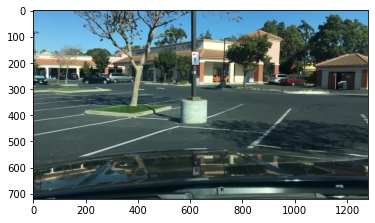

In [16]:
import torch.nn.functional as F
print(tensor_image.shape)
import matplotlib.pyplot as plt

from torchvision import transforms
im = transforms.ToPILImage()(tensor_image).convert("RGB")
plt.imshow(im)

In [17]:
#out = F.interpolate(img, size=(72,128))

# tensor_image = read_image("bdd100k_images/images/100k/train/5a2a8521-8c9ea049.jpg")
# tensor_image = tensor_image.unsqueeze(0)
# out = F.interpolate(tensor_image, size=(72,128))
# out = out.squeeze()
# im = transforms.ToPILImage()(out).convert("RGB")
# plt.imshow(im)

# t = transforms.Resize((72,128), interpolation=Image.BICUBIC)

# out = t(tensor_image)
# out = out.squeeze()
# im = transforms.ToPILImage()(out).convert("RGB")
# plt.imshow(im)


In [18]:
# train_num = trainX.shape[0]
# test_num = testX.shape[0]
# x_dim = trainX.shape[2]
# y_dim = trainX.shape[1]
# val_num = valX.shape[0]



# Pytorch CNN Model

Module is the baseclass for all NN module:
https://pytorch.org/docs/stable/generated/torch.nn.Module.html

### Conv2D -> 
Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
https://cs231n.github.io/convolutional-networks/
out_channels = number of kernels (filters) used, so dim in the 3rd dim


### BatchNorm2d ->
BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Batch normalization normalizes the activations of the network between layers in batches so that the batches have a mean of 0 and a variance of 1.
param = num of channels

### nn.Linear ->
Linear(in_features, out_features, bias=True)



### Convert to PyTorch types

In [19]:
# import torch
# # train

# trainX = trainX.reshape(train_num, 3, y_dim, x_dim).astype(float)
# print(trainX[0])
# print(trainX.shape)
# trainX  = torch.from_numpy(trainX).type(torch.FloatTensor)

# # trainY = trainY.reshape(train_num, 1, x_dim, y_dim).astype(float)
# # trainY  = torch.from_numpy(trainY)
# # print(trainY.shape)

# trainY = trainY.reshape(train_num, 1, y_dim, x_dim).astype(float)
# #trainY  = torch.from_numpy(trainY).type(torch.LongTensor)
# trainY  = torch.from_numpy(trainY).type(torch.FloatTensor)
# print(trainY.shape)



# # val
# valX = valX.reshape(val_num, 3, y_dim, x_dim).astype(float)
# print(valX[0])
# print(valX.shape)
# valX  = torch.from_numpy(valX).type(torch.FloatTensor)

# # valY = valY.reshape(val_num, 1, x_dim, y_dim).astype(float)
# # valY  = torch.from_numpy(valY)


# valY = valY.reshape(val_num, 1, y_dim, x_dim).astype(float)
# #valY  = torch.from_numpy(valY).type(torch.LongTensor)
# valY  = torch.from_numpy(valY).type(torch.FloatTensor)
# # //TODO Test




In [20]:
# trainX.shape, trainY.shape

In [21]:
# PyTorch libraries and modules
#model 4

import torch
from torch.autograd import Variable
from torch.nn import Linear, Softmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
from torch.optim import Adam, SGD
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

modelRun = False
storeImg = []

class CNN(Module):
    def __init__(self):
        super(CNN,self).__init__() #base class for all neural network modules
        input_chan = 3
        out_chan_1 = 6 #before 3
        out_chan_2 = 12 # before 5
        out_chan_3 = 24
        out_chan_4 = 48
        
        k_s_1 = 3
        k_s_2 = 3
        k_s_m = 2

        
        num_neurons_1 = 10
        
        output_size = 9216 #depending on num of pixels
        
        self.cnn_1 = Sequential(
            # Defining a 2D convolution layer
            Conv2d(input_chan, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
            ReLU(inplace=True),
            BatchNorm2d(out_chan_1), #just specify the num of output channels
            #Sigmoid(),
            Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
            ReLU(inplace=True),
            BatchNorm2d(out_chan_1),
            # Defining another 2D convolution layer
        )
        
        self.cnn_2 = Sequential(
            MaxPool2d(kernel_size=k_s_m, stride=1),
            Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_2),
            #Softmax(),
            Conv2d(out_chan_2, out_chan_2, kernel_size=k_s_2, stride=1, padding=1), 
            ReLU(inplace=True),
            BatchNorm2d(out_chan_2),
        )
        
        self.cnn_3 = Sequential(
            MaxPool2d(kernel_size=k_s_m, stride=1),
            Conv2d(out_chan_2, out_chan_3, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_3),
            #Softmax(),
            Conv2d(out_chan_3, out_chan_3, kernel_size=k_s_2, stride=1, padding=1), 
            ReLU(inplace=True),
            BatchNorm2d(out_chan_3),
        )
        
        
        self.pool_down_and_up = Sequential(
            MaxPool2d(kernel_size=k_s_m, stride=1),
            Conv2d(out_chan_3, out_chan_4, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_4),
            #Softmax(),
            Conv2d(out_chan_4, out_chan_4, kernel_size=k_s_2, stride=1, padding=1), 
            ReLU(inplace=True),
            BatchNorm2d(out_chan_4),
            nn.ConvTranspose2d(out_chan_4,out_chan_3,kernel_size=k_s_m, stride=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_3)
        )
        
        
        self.up1 = Sequential (
            Conv2d(out_chan_3+out_chan_3, out_chan_3, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_3),
            Conv2d(out_chan_3, out_chan_3, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_3),
            nn.ConvTranspose2d(out_chan_3,out_chan_2,kernel_size=k_s_m, stride=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_2),
            #nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1)
        )
        
        self.up2 = Sequential (

            Conv2d(out_chan_2+out_chan_2, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_2),
            Conv2d(out_chan_2, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_2),
            nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_m, stride=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_1),     
            
            
        )
        
        
#         self.up3 = Sequential (
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
#             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_m, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
            
#         )
        
        
        #one to one convolution
        self.oneToOne = Sequential(
            Conv2d(out_chan_1+out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(out_chan_1),
            Conv2d(out_chan_1, 1, kernel_size=1, stride=1),
            ReLU(inplace=True),
            BatchNorm2d(1)

        )
        
        
        #functions used for helping show intermediate CNN output
        self.set_dim_1 = Sequential(
            Conv2d(out_chan_1, 1,kernel_size=k_s_1, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(1),
            
        )
        
        self.set_dim_2 = Sequential(
            Conv2d(out_chan_2, 1,kernel_size=k_s_1, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(1),
            
        )
        
    #from tutorial - used for copy and cropping
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

        
        
    # Defining the forward pass    
    def forward(self, x):
        if modelRun:
            x1 = self.cnn_1(x)
            
            x1_reshape = self.set_dim_1(x1)
            storeImg.append(x1_reshape.cpu().detach().numpy())
            
            x2 = self.cnn_2(x1)
            
            x2_reshape = self.set_dim_2(x2)
            storeImg.append(x2_reshape.cpu().detach().numpy())
            
             #max pool -> down a layer
            x3 = self.cnn_3(x2)
            print("after cnn_3")
            print(x3.size())
            
            #max pool -> down a layer
            x4 = self.pool_down_and_up(x3)
            print("after cnn_4")
            print(x4.size())
            # up-conv and back up a layer
            x4 = self.crop_and_concat(x3, x4, crop=True)
            
            x = self.up1(x4)
            print("after up_1")
            print(x.size())
            # up-conv and back up a layer
            
            
            x = self.crop_and_concat(x2, x, crop=True)
            
            x = self.up2(x)
            print("after up_2")
            print(x.size()) 
            # up-conv and back up
            
            x = self.crop_and_concat(x1, x, crop=True)
            
            x = self.oneToOne(x)


        
        else:
            x1 = self.cnn_1(x)
            print("after cnn_1")
            print(x1.size())
            
            #max pool -> down a layer
            x2 = self.cnn_2(x1) 
            print("after cnn_2")
            print(x2.size())
            
            #max pool -> down a layer
            x3 = self.cnn_3(x2)
            print("after cnn_3")
            print(x3.size())
            
            #max pool -> down a layer
            x4 = self.pool_down_and_up(x3)
            print("after cnn_4")
            print(x4.size())
            # up-conv and back up a layer
            x4 = self.crop_and_concat(x3, x4, crop=True)
            
            x = self.up1(x4)
            print("after up_1")
            print(x.size())
            # up-conv and back up a layer
            
            
            x = self.crop_and_concat(x2, x, crop=True)
            
            x = self.up2(x)
            print("after up_2")
            print(x.size()) 
            # up-conv and back up
            
            x = self.crop_and_concat(x1, x, crop=True)
            
            x = self.oneToOne(x)
            
            
        return x
    

#### Finding the correct dimension

In [22]:
lr = 0.005
# defining the model
model = CNN()
# defining the optimizer
#optimizer =  torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=0.0005)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=0.9)
optimizer = Adam(model.parameters(), lr=0.00005)


#scheduler - not used
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2) #changes the learning rate based on epoch


# defining the loss function
#criterion = MSELoss()
#criterion = CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
# print(model)

# trainX = trainX[:2].cuda()

# output = model(Variable(trainX))
# output



def train(epoch, train_x, train_y, val_x, val_y):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    #x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
#         x_val = x_val.cuda()
#         y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    #output_val = model(x_val)

    # computing the training and validation loss
    print(output_train.shape)
    print(y_train.shape)
    loss_train = criterion(output_train, y_train)
    #loss_val = criterion(output_val, y_val)
    #train_losses.append(loss_train)
    #val_losses.append(loss_val)
    
    batch_loss.append(loss_train)
#     train_temp += loss_train
    
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    
    tr_loss = loss_train.item()
    
    #scheduler.step(tr_loss) #decreases the learning rate as we go
    
    
#     if epoch%2 == 0:
#         # printing the validation loss
#         print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
     
    # delete this things that aren't necessary for the next iteration
#     del loss_train
#     del loss_val
#     del output_train
#     del output_val
    
    return train_temp

In [23]:
#testing load of prev saved weights
model.load_state_dict(torch.load("4epoch_model_param.pt"))


<All keys matched successfully>

In [24]:
# defining the number of epochs
n_epochs = 2

batch_loss = []
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    lossVal = 0
    train_temp = 0
    counter = 0
    for batch in train_loader:
        imgs = batch['image']
        labels = batch['label']
        train_temp += train(epoch, imgs, labels, valX, valY)
        #loss_val += val
#         if counter > 50:
#             break
        counter += 1
        
        
    #val_losses.append(loss_val)
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', train_temp)
        
    #torch.save(model.state_dict(), str(epoch) + "epoch_model_param.pt")
    train_losses.append(train_temp)
    #break

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])
after cnn_3
torch.Size([75, 24, 70, 126])
after cnn_4
torch.Size([75, 24, 70, 126])
after up_1
torch.Size([75, 12, 71, 127])
after up_2
torch.Size([75, 6, 72, 128])
torch.Size([75, 1, 72, 128])
torch.Size([75, 1, 72, 128])
after cnn_1
torch.Size([75, 3, 72, 128])
after cnn_2
torch.Size([75, 12, 71, 127])

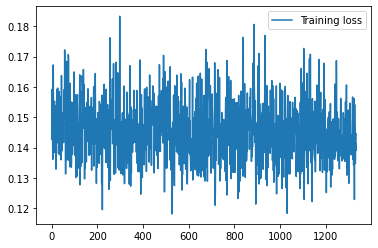

In [25]:
torch.save(model.state_dict(), "6epoch_model_param.pt")
import matplotlib.pyplot as plt 
plt.plot(batch_loss, label='Training loss')
#plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [26]:
# torch.cuda.empty_cache()




#discussion with Chau

should label data be 0 and 1 per pixel rather than whatever it currently is?
should we normalize all the images to be closer to 1 rather than such large numbers?
should just discussion on loss function -> i think mseloss would be best for pixel by pixel comparison?
should final output be filtered using something other than nerual network?


In [5]:
for batch in val_loader:
    imgs = batch['image']
    labels = batch['label']
    break

print(imgs.shape)
print(imgs[0].shape)

NameError: name 'val_loader' is not defined

In [4]:
#imNum = 8

imNum = 181
modelRun = True
storeImg = []

testSingle = imgs[imNum:imNum+1]
testSingle = testSingle.cuda()
#testSingle = testSingle
y_pred = model(testSingle)


out = y_pred.cpu().detach().numpy()

#print(valY[imNum].numpy().shape)

# print(out)
# print("Max:")
# print(np.max(out))
avg = np.mean(out)
print(avg)


final = np.where(out > avg+6, 1, 0)


final = np.reshape(final, (ySize,xSize))*255.0

out = np.reshape(out, (ySize,xSize))

#actual = ((np.reshape(labels[imNum].numpy(), (ySize, xSize)))*255)
actual = labels[imNum]

print(actual)

print(out)

NameError: name 'imgs' is not defined

In [2]:
# im = Image.fromarray((final).astype(np.uint8))
# im.show()

# im2 = Image.fromarray(actual.astype(np.uint8))
# im2.show()
avg = np.mean(out)
print(avg)

NameError: name 'np' is not defined

In [3]:
import matplotlib.pyplot as plt

plt.imshow(actual.numpy()[0],cmap="Greys")

NameError: name 'actual' is not defined

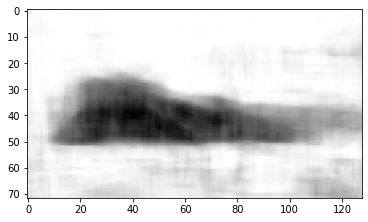

In [225]:
plt.imshow(out, cmap="Greys")

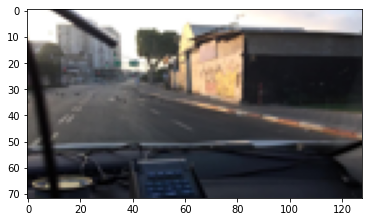

In [226]:
#plt.imshow(np.reshape(imgs[imNum], (ySize,xSize,3)))
#type(imgs[imNum])

plt.imshow(imgs[imNum].permute(1, 2, 0)  )

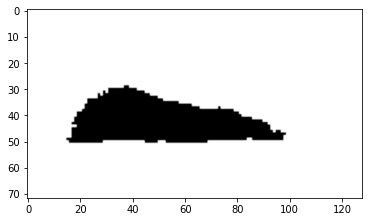

In [227]:
plt.imshow(final, cmap="Greys")

In [34]:
#plt.imshow(np.reshape(valX[imNum].numpy(), (ySize,xSize,3)), cmap="Greys")
storeImg[0][0][0].shape
np.resize(storeImg[0][0][0], (ySize,xSize))

array([[-0.21704638, -0.21704638, -0.21704638, ..., -0.21704638,
        -0.21704638, -0.21704638],
       [-0.21704638, -0.21704638, -0.21704638, ..., -0.21704638,
        -0.21704638, -0.21704638],
       [-0.21704638, -0.21704638, -0.21704638, ..., -0.21704638,
        -0.21704638, -0.21704638],
       ...,
       [-0.21704638, -0.21704638, -0.21704638, ..., -0.09844863,
        -0.21704638, -0.21704638],
       [-0.21704638, -0.21704638, -0.21704638, ..., -0.21704638,
        -0.21704638, -0.05774039],
       [-0.21704638, -0.21704638,  0.4344882 , ...,  0.6244258 ,
         0.66834915,  0.39602867]], dtype=float32)

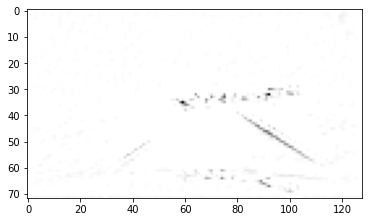

In [35]:
plt.imshow(np.resize(storeImg[0][0][0], (ySize,xSize)), cmap="Greys")

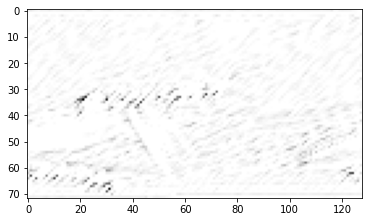

In [36]:
plt.imshow(np.resize(storeImg[1][0][0], (ySize,xSize)), cmap="Greys")

In [44]:
def val_accuracy(val_loader, model):
    val_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        label1_sum = 0
        pixel_count = 0
        batch_count = 0
        for batch in val_loader:
            imgs = batch['image']
            labels = batch['label']
            #img, labels = imgs.to(device), labels.to(device)  ## for GPU
            
            imgs, labels = Variable(imgs), Variable(labels)
            # getting the validation set
            #x_val, y_val = Variable(val_x), Variable(val_y)
            # converting the data into GPU format
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            
            predictions = model.forward(imgs)
            batch_loss = criterion(predictions, labels)
            val_loss += batch_loss.item()
            val_losses.append(batch_loss.item())

            ps = torch.exp(predictions)
            top_p, top_class = ps.topk(1, dim=1)
            equals = (top_class == labels.view(*top_class.shape))

#             plt.imshow(equals[0,:, :, :].numpy().reshape((72, 128)))
#             plt.show()
            #accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            label1_sum += equals.cpu().numpy().sum()

            pixel_count += np.prod(equals.size())
#             val_loss = val_loss/len(val_loader)
#             val_accuracy = accuracy/len(val_loader)
            print("Batch Accuracy {:.5f}".format(equals.cpu().numpy().mean()))
            print(f"Batch Loss: {batch_loss.item():.5f}")
            batch_count+=1

#             print(f"Validation loss: {val_loss:.5f}.. "
#                   f"Validation accuracy: {val_accuracy:.5f}")
            #yield test_loss, accuracy
        return label1_sum / pixel_count, val_loss / batch_count, val_losses
#this is how I call it
#accuracy, avg_val_loss, val_losses = val_accuracy(test_loader, model)
test_accuracy, avg_test_loss, test_losses = val_accuracy(test_loader, model)

after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81863
Batch Loss: 0.15544
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81256
Batch Loss: 0.14964
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81549
Batch Loss: 0.13845
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80783
Batch Loss: 0.15095
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([2

Batch Accuracy 0.82458
Batch Loss: 0.14474
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80414
Batch Loss: 0.15110
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81515
Batch Loss: 0.14827
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81560
Batch Loss: 0.15158
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80746
Batch Loss: 0.14482
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([

Batch Accuracy 0.81457
Batch Loss: 0.14221
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80573
Batch Loss: 0.14557
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81898
Batch Loss: 0.14563
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81700
Batch Loss: 0.14462
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81168
Batch Loss: 0.15152
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([

Batch Accuracy 0.81617
Batch Loss: 0.14283
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80797
Batch Loss: 0.13756
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81598
Batch Loss: 0.14417
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.82198
Batch Loss: 0.15266
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81014
Batch Loss: 0.14038
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([

Batch Accuracy 0.81282
Batch Loss: 0.14210
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80434
Batch Loss: 0.13634
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80735
Batch Loss: 0.14687
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.81783
Batch Loss: 0.14434
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([256, 12, 71, 127])
after up_2
torch.Size([256, 6, 72, 128])
Batch Accuracy 0.80540
Batch Loss: 0.14562
after cnn_3
torch.Size([256, 24, 70, 126])
after cnn_4
torch.Size([256, 24, 70, 126])
after up_1
torch.Size([

Batch Accuracy 0.81506
Batch Loss: 0.14518
after cnn_3
torch.Size([80, 24, 70, 126])
after cnn_4
torch.Size([80, 24, 70, 126])
after up_1
torch.Size([80, 12, 71, 127])
after up_2
torch.Size([80, 6, 72, 128])
Batch Accuracy 0.82031
Batch Loss: 0.14660


In [38]:
print("Accuracy")
print(accuracy)
print("Avg Val Loss")
print(avg_val_loss)

Accuracy
0.8138010069444445
Avg Val Loss
0.1447456022914575


In [45]:
print("Test Accuracy")
print(test_accuracy)
print("Avg Test Loss")
print(avg_test_loss)

Test Accuracy
0.8138010069444445
Avg Test Loss
0.14477347263268062


In [39]:
# Works really well!!!! Model 1 as referred to in the progress tracker 03/15
# # PyTorch libraries and modules
# import torch
# from torch.autograd import Variable
# from torch.nn import Linear, Softmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
# from torch.optim import Adam, SGD
# import torch.nn as nn
# import torch.nn.functional as F
# from torch import optim

# modelRun = False
# storeImg = []

# class CNN(Module):
#     def __init__(self):
#         super(CNN,self).__init__() #base class for all neural network modules
#         out_chan_1 = 3
#         out_chan_2 = 7
#         k_s_1 = 3
#         k_s_2 = 3

        
#         num_neurons_1 = 10
        
#         output_size = 9216 #depending on num of pixels
        
#         self.cnn_1 = Sequential(
#             # Defining a 2D convolution layer
#             Conv2d(3, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1), #just specify the num of output channels
#             #Sigmoid(),
            
#             MaxPool2d(kernel_size=k_s_1, stride=1),
#             # Defining another 2D convolution layer
#         )
        
#         self.cnn_2 = Sequential(
#             Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_2),
#             #Softmax(),
            
#             MaxPool2d(kernel_size=k_s_2, stride=1)
#         )
#         self.up1 = Sequential (
#             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
            
            
#             #nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1)
#         )
        
#         self.up2 = Sequential (
#             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
            
#         )
        
        
#         #one to one convolution
#         self.oneToOne = Sequential(
#             nn.ConvTranspose2d(out_chan_1,1,kernel_size=1, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
            
#         )
        
        
#         #functions used for helping show intermediate CNN output
#         self.set_dim_1 = Sequential(
#             Conv2d(out_chan_1, 1,kernel_size=k_s_1, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
            
#         )
        
#         self.set_dim_2 = Sequential(
#             Conv2d(out_chan_2, 1,kernel_size=k_s_1, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
            
#         )
        
#         #from tutorial - used for copy and cropping
#         def crop_and_concat(self, upsampled, bypass, crop=False):
#             if crop:
#                 c = (bypass.size()[2] - upsampled.size()[2]) // 2
#                 bypass = F.pad(bypass, (-c, -c, -c, -c))
#             return torch.cat((upsampled, bypass), 1)

        
        
#     # Defining the forward pass    
#     def forward(self, x):
#         if modelRun:
#             x1 = self.cnn_1(x)
            
#             x1_reshape = self.set_dim_1(x1)
#             storeImg.append(x1_reshape.cpu().detach().numpy())
            
#             x2 = self.cnn_2(x1)
            
#             x2_reshape = self.set_dim_2(x2)
#             storeImg.append(x2_reshape.cpu().detach().numpy())
            
#             x3 = self.up1(x2)
            
#             x = self.up2(x3)
            
#             x = self.oneToOne(x)


        
#         else:
#             x = self.cnn_1(x)
#             print("after cnn_1")
#             print(x.size())
#             x = self.cnn_2(x)
#             print("after cnn_2")
#             print(x.size())
#             x = self.up1(x)
#             print("after up_1")
#             print(x.size())     
#             x = self.up2(x)
#             print("after up_1")
#             print(x.size())   
            
#             x = self.oneToOne(x)
            
            
#         return x
    

In [40]:
# RUNS FINE
# # PyTorch libraries and modules
# import torch
# from torch.autograd import Variable
# from torch.nn import Linear, Softmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
# from torch.optim import Adam, SGD
# import torch.nn as nn
# import torch.nn.functional as F
# from torch import optim

# modelRun = False
# storeImg = []

# class CNN(Module):
#     def __init__(self):
#         super(CNN,self).__init__() #base class for all neural network modules
#         out_chan_1 = 3
#         out_chan_2 = 7
#         k_s_1 = 3
#         k_s_2 = 3

        
#         num_neurons_1 = 10
        
#         output_size = 9216 #depending on num of pixels
        
#         self.cnn_1 = Sequential(
#             # Defining a 2D convolution layer
#             Conv2d(3, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
#             BatchNorm2d(out_chan_1), #just specify the num of output channels
#             #Sigmoid(),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_1, stride=1),
#             # Defining another 2D convolution layer
#         )
        
#         self.cnn_2 = Sequential(
#             Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_2),
#             #Softmax(),
#             ReLU(inplace=True),
#             MaxPool2d(kernel_size=k_s_2, stride=1)
#         )
#         self.up1 = Sequential (
#             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             nn.ConvTranspose2d(out_chan_1,1,kernel_size=k_s_2, stride=1),
#             BatchNorm2d(1),
#             ReLU(inplace=True),
            
#             #nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1)
#         )
        
#         #functions used for helping show intermediate CNN output
#         self.set_dim_1 = Sequential(
#             Conv2d(out_chan_1, 1,kernel_size=k_s_1, stride=1, padding=1),
#             BatchNorm2d(1),
#             ReLU(inplace=True)
#         )
        
#         self.set_dim_2 = Sequential(
#             Conv2d(out_chan_2, 1,kernel_size=k_s_1, stride=1, padding=1),
#             BatchNorm2d(1),
#             ReLU(inplace=True)
#         )
        
        
        
#     # Defining the forward pass    
#     def forward(self, x):
#         if modelRun:
#             x1 = self.cnn_1(x)
            
#             x1_reshape = self.set_dim_1(x1)
#             storeImg.append(x1_reshape.cpu().detach().numpy())
            
#             x2 = self.cnn_2(x1)
            
#             x2_reshape = self.set_dim_2(x2)
#             storeImg.append(x2_reshape.cpu().detach().numpy())
            
#             x = self.up1(x2)


        
#         else:
#             x = self.cnn_1(x)
#             print(x.size())
#             x = self.cnn_2(x)
#             print(x.size())
#             x = self.up1(x)
            
#         return x
    

In [41]:
# class CNN(Module):
#     def __init__(self):
#         super(CNN,self).__init__() #base class for all neural network modules
#         out_chan_1 = 5
#         out_chan_2 = 7
#         out_chan_3 = 3
#         k_s_1 = 3
#         k_s_2 = 3
# #         k_s_1_mp = 2 #mp = max pool
# #         k_s_2_mp = 2
        
#         num_neurons_1 = 10
        
#         output_size = 9216 #depending on num of pixels
        
#         self.cnn_1 = Sequential(
#             # Defining a 2D convolution layer
#             Conv2d(3, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
#             BatchNorm2d(out_chan_1), #just specify the num of output channels
#             ReLU(inplace=True),
# #             MaxPool2d(kernel_size=k_s_1, stride=1),
#             # Defining another 2D convolution layer
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_1, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#         )
        
#         self.cnn_2 = Sequential(
#             MaxPool2d(kernel_size=k_s_1, stride=2), #downscale
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             #MaxPool2d(kernel_size=k_s_2, stride=1),
#         )
        
        
#         self.cnn_3 = Sequential(
#             MaxPool2d(kernel_size=k_s_2, stride=2), #downscale
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             #MaxPool2d(kernel_size=k_s_2, stride=1),
#         )
        
        
        
        
# #         self.up_2 = Sequential (
# #             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1)
# #             #nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1)
# #         )
        
        
#         self.up_1 = Sequential(
#             #Conv2d(out_chan_3, 1, kernel_size=1, stride=1, padding=1),
#             #nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
#             #Sigmoid(),
#             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=2), #upscale
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
            
# #             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=2),
# #             nn.ConvTranspose2d(out_chan_1,1,kernel_size=k_s_1, stride=1)
#         )
        
        
#         self.up_2 = Sequential(
#             #Conv2d(out_chan_3, 1, kernel_size=1, stride=1, padding=1),
#             #nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
#             #Sigmoid(),
#             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_1, stride=2), #upscale
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(out_chan_1),
#             ReLU(inplace=True),
#             Conv2d(out_chan_1, 1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(1),
#             ReLU(inplace=True),
            
# #             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=2),
# #             nn.ConvTranspose2d(out_chan_1,1,kernel_size=k_s_1, stride=1)
#         )
        
#         self.out_conv = Sequential(
#             Conv2d(1, 1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(1),
#             ReLU(inplace=True),
#         )
        
        
#         self.set_chan = Sequential(
#             Conv2d(5, 1, kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(1),
#             ReLU(inplace=True)
#         )
        
#         self.set_dim = Sequential(
#             Conv2d(5, 1,kernel_size=k_s_2, stride=1, padding=1),
#             BatchNorm2d(1),
#             ReLU(inplace=True)
#         )
        
        
# #         self.up_3 = Sequential(
# #             #Conv2d(out_chan_3, 1, kernel_size=1, stride=1, padding=1),
# #             #nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
# #             #Sigmoid(),
# #             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_1, stride=2),
# #             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
# #             BatchNorm2d(out_chan_1),
# #             ReLU(inplace=True),
# #             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
# #             BatchNorm2d(out_chan_1),
# #             ReLU(inplace=True),
            
# # #             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=2),
# # #             nn.ConvTranspose2d(out_chan_1,1,kernel_size=k_s_1, stride=1)
# #         )
        
        
# #         self.linear_layers = Sequential(
# #             Linear(out_chan_2 * 31 * 17, num_neurons_1),
# #             Softmax(dim=1),
# #             #ReLU(inplace=True),
# #             Linear(num_neurons_1,output_size),
# #             Sigmoid() # map from 0 to 1
# #             #Softmax(dim=1)
# #             #Sign()
# #             #ReLU(inplace=True)
            
# #         )
        
#     # Defining the forward pass    
#     def forward(self, x):
#         if modelRun:
#             print("Start: ")
#             print(x.size())

#             x1 = self.cnn_1(x)

#             print("1st Conv: ")
#             print(x1.size())
#             print("shape:")
#             print((x1).cpu().detach().numpy().shape)
#             x1_reshape = self.set_dim(x1)
#             storeImg.append(x1_reshape.cpu().detach().numpy())
            
#             x2 = self.cnn_2(x1)

#             print("2nd Conv: ")
#             print(x2.size())
#             x2_reshape = self.set_dim(x2)
#             storeImg.append(x2_reshape.cpu().detach().numpy())

#             x3 = self.cnn_3(x2)
#             print("3rd Conv: ")
#             print(x3.size())
#             x3_reshape = self.set_dim(x3)
#             storeImg.append(x3_reshape.cpu().detach().numpy())

#     #         x1 = x2+x1

#             x4 = self.up_1(x3)

#             print("Upscale 1: ")
#             print(x4.size())

#             #x4 = x4 + x2

#             x5 = self.up_2(x4)

#             print("Upscale 2: ")
#             print(x5.size())



#             diffY = x1.size()[2] - x5.size()[2]
#             diffX = x1.size()[3] - x5.size()[3]
#             x5 = F.pad(x5, [diffX//2, diffX - diffX//2,
#                            diffY//2, diffY - diffY//2])
#             x6 = torch.cat([x1, x5], dim=1)


#             #x1 = self.set_chan(x1)
#             #x5 = x5 + x1

#             x6 = self.out_conv(x5)
#             print("Out: ")
#             print(x6.size())
#         else:
#             #print("Start: ")
#             #print(x.size())

#             x1 = self.cnn_1(x)
#             x1_reshape = self.set_dim(x1)

#             #print("1st Conv: ")
#             #print(x1.size())

#             x2 = self.cnn_2(x1)

#             #print("2nd Conv: ")
#             #print(x2.size())


#             x3 = self.cnn_3(x2)
# #            print("3rd Conv: ")
# #            print(x3.size())

#     #         x1 = x2+x1

#             x4 = self.up_1(x3)

# #            print("Upscale 1: ")
# #            print(x4.size())

#             #x4 = x4 + x2

#             x5 = self.up_2(x4)

# #            print("Upscale 2: ")
# #            print(x5.size())



#             diffY = x1.size()[2] - x5.size()[2]
#             diffX = x1.size()[3] - x5.size()[3]
#             x5 = F.pad(x5, [diffX//2, diffX - diffX//2,
#                            diffY//2, diffY - diffY//2])
#             x6 = torch.cat([x1, x5], dim=1)


#             #x1 = self.set_chan(x1)
#             #x5 = x5 + x1

#             x6 = self.out_conv(x5)
#             #print("Out: ")
#             #print(x6.size())
        
# #         x3 = self.up_1(x2)
# #         print(x3.size())
        
#         #x2 = x1 + x2
        
#         #x1 = x3 + x1
#         #print(x2.size())
# #         x = self.output(x)
#         #x=x.long()
#         #x = x.view(x.size(0), -1)
        
#         #x = self.linear_layers(x)
#         #x = x.float()
#         return x6
    

In [42]:
# Model 2 - works with bypass layer
# # PyTorch libraries and modules
# import torch
# from torch.autograd import Variable
# from torch.nn import Linear, Softmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
# from torch.optim import Adam, SGD
# import torch.nn as nn
# import torch.nn.functional as F
# from torch import optim

# modelRun = False
# storeImg = []

# class CNN(Module):
#     def __init__(self):
#         super(CNN,self).__init__() #base class for all neural network modules
#         out_chan_1 = 3
#         out_chan_2 = 7
#         k_s_1 = 3
#         k_s_2 = 3

        
#         num_neurons_1 = 10
        
#         output_size = 9216 #depending on num of pixels
        
#         self.cnn_1 = Sequential(
#             # Defining a 2D convolution layer
#             Conv2d(3, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1), #just specify the num of output channels
#             #Sigmoid(),
            
#             MaxPool2d(kernel_size=k_s_1, stride=1),
#             # Defining another 2D convolution layer
#         )
        
#         self.cnn_2 = Sequential(
#             Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_2),
#             #Softmax(),
            
#             MaxPool2d(kernel_size=k_s_2, stride=1)
#         )
#         self.up1 = Sequential (
#             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
            
            
#             #nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1)
#         )
        
#         self.up2 = Sequential (
#             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
            
#         )
        
        
#         #one to one convolution
#         self.oneToOne = Sequential(
#             nn.ConvTranspose2d(6,1,kernel_size=1, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
#         )
        
        
#         #functions used for helping show intermediate CNN output
#         self.set_dim_1 = Sequential(
#             Conv2d(out_chan_1, 1,kernel_size=k_s_1, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
            
#         )
        
#         self.set_dim_2 = Sequential(
#             Conv2d(out_chan_2, 1,kernel_size=k_s_1, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
            
#         )
        
#     #from tutorial - used for copy and cropping
#     def crop_and_concat(self, upsampled, bypass, crop=False):
#         if crop:
#             c = (bypass.size()[2] - upsampled.size()[2]) // 2
#             bypass = F.pad(bypass, (-c, -c, -c, -c))
#         return torch.cat((upsampled, bypass), 1)

        
        
#     # Defining the forward pass    
#     def forward(self, x):
#         if modelRun:
#             x1 = self.cnn_1(x)
            
#             x1_reshape = self.set_dim_1(x1)
#             storeImg.append(x1_reshape.cpu().detach().numpy())
            
#             x2 = self.cnn_2(x1)
            
#             x2_reshape = self.set_dim_2(x2)
#             storeImg.append(x2_reshape.cpu().detach().numpy())
            
#             x3 = self.up1(x2)
            
#             x = self.up2(x3)
            
#             x = self.crop_and_concat(x, x1, crop=True)
            
#             x = self.oneToOne(x)


        
#         else:
#             x1 = self.cnn_1(x)
#             print("after cnn_1")
#             print(x.size())
#             x = self.cnn_2(x1)
#             print("after cnn_2")
#             print(x.size())
#             x = self.up1(x)
#             print("after up_1")
#             print(x.size())     
#             x = self.up2(x)
#             print("after up_1")
#             print(x.size())   
            
#             x = self.crop_and_concat(x, x1, crop=True)
            
#             x = self.oneToOne(x)
            
            
#         return x
    


In [43]:
# PyTorch libraries and modules
# Model 3 - more convolutions in each layer
# import torch
# from torch.autograd import Variable
# from torch.nn import Linear, Softmax, Sigmoid, ReLU, NLLLoss, MSELoss, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Flatten
# from torch.optim import Adam, SGD
# import torch.nn as nn
# import torch.nn.functional as F
# from torch import optim

# modelRun = False
# storeImg = []

# class CNN(Module):
#     def __init__(self):
#         super(CNN,self).__init__() #base class for all neural network modules
#         out_chan_1 = 5 #before 3
#         out_chan_2 = 9 # before 5
#         k_s_1 = 3
#         k_s_2 = 3

        
#         num_neurons_1 = 10
        
#         output_size = 9216 #depending on num of pixels
        
#         self.cnn_1 = Sequential(
#             # Defining a 2D convolution layer
#             Conv2d(3, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1), #just specify the num of output channels
#             #Sigmoid(),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_1, stride=1, padding=1), 
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
#             MaxPool2d(kernel_size=k_s_1, stride=1),
#             # Defining another 2D convolution layer
#         )
        
#         self.cnn_2 = Sequential(
#             Conv2d(out_chan_1, out_chan_2, kernel_size=k_s_2, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_2),
#             #Softmax(),
#             Conv2d(out_chan_2, out_chan_2, kernel_size=k_s_2, stride=1, padding=1), 
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_2),
#             MaxPool2d(kernel_size=k_s_2, stride=1)
#         )
#         self.up1 = Sequential (
#             nn.ConvTranspose2d(out_chan_2,out_chan_1,kernel_size=k_s_2, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
            
#             #nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1)
#         )
        
#         self.up2 = Sequential (
#             nn.ConvTranspose2d(out_chan_1,out_chan_1,kernel_size=k_s_2, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
#             Conv2d(out_chan_1, out_chan_1, kernel_size=k_s_2, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(out_chan_1),
            
#         )
        
        
#         #one to one convolution
#         self.oneToOne = Sequential(
#             nn.ConvTranspose2d(10,1,kernel_size=1, stride=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
#         )
        
        
#         #functions used for helping show intermediate CNN output
#         self.set_dim_1 = Sequential(
#             Conv2d(out_chan_1, 1,kernel_size=k_s_1, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
            
#         )
        
#         self.set_dim_2 = Sequential(
#             Conv2d(out_chan_2, 1,kernel_size=k_s_1, stride=1, padding=1),
#             ReLU(inplace=True),
#             BatchNorm2d(1),
            
#         )
        
#     #from tutorial - used for copy and cropping
#     def crop_and_concat(self, upsampled, bypass, crop=False):
#         if crop:
#             c = (bypass.size()[2] - upsampled.size()[2]) // 2
#             bypass = F.pad(bypass, (-c, -c, -c, -c))
#         return torch.cat((upsampled, bypass), 1)

        
        
#     # Defining the forward pass    
#     def forward(self, x):
#         if modelRun:
#             x1 = self.cnn_1(x)
            
#             x1_reshape = self.set_dim_1(x1)
#             storeImg.append(x1_reshape.cpu().detach().numpy())
            
#             x2 = self.cnn_2(x1)
            
#             x2_reshape = self.set_dim_2(x2)
#             storeImg.append(x2_reshape.cpu().detach().numpy())
            
#             x3 = self.up1(x2)
            
#             x = self.up2(x3)
            
#             x = self.crop_and_concat(x, x1, crop=True)
            
#             x = self.oneToOne(x)


        
#         else:
#             x1 = self.cnn_1(x)
#             print("after cnn_1")
#             print(x.size())
#             x = self.cnn_2(x1)
#             print("after cnn_2")
#             print(x.size())
#             x = self.up1(x)
#             print("after up_1")
#             print(x.size())     
#             x = self.up2(x)
#             print("after up_1")
#             print(x.size())   
            
#             x = self.crop_and_concat(x, x1, crop=True)
            
#             x = self.oneToOne(x)
            
            
#         return x
    

In [1]:
import sys
print(sys.version)

3.7.9 (default, Aug 18 2020, 06:24:24) 
[GCC 5.4.0 20160609]
